In [ ]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

#%% Change working directory from the workspace root to the ipynb file location. Turn this addition off with the DataSciece.changeDirOnImportExport setting
import os
try:
    os.chdir(r'C:\Users\kevin\Documents\Workspace\psylit-experiments\src')
    print("Changed cwd:", os.getcwd())
except:
    print("cwd:", os.getcwd())

from IPython.display import display, Markdown, Latex
from collections import *
from statistics import mean
from functools import *
from os import linesep as EOL
from itertools import *
import re
import json
import pathlib
import glob
import math

import spacy
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
import plotly as py

from models.cascades import *
from viz.cascades import *
from utils.misc import progress

py.offline.init_notebook_mode()
np.random.seed(0)

In [2]:
plt.rcParams['figure.figsize'] = 16,10

In [17]:
from experiments.block_entropy import BlockEntropy_StimulusResponse as Experiment
ROOT = pathlib.Path().resolve()
DATA_ROOT = ROOT.parent  / 'data' / 'analytics'
print(ROOT)
print(DATA_ROOT)

Experiment.clear_missing_results(DATA_ROOT)

C:\Users\kevin\Documents\Workspace\psylit-experiments\src
C:\Users\kevin\Documents\Workspace\psylit-experiments\data\analytics


In [294]:
BLOCK_ENT = '$H(k)$'
EXCESS_ENT = '$\eta^{(k)}$'
ENT_RATE = '$h^{(k)}$'

In [290]:
results = Experiment.load_all_results(DATA_ROOT, run_col_name='Document')
results = results['persubj']
results.pop('Unnamed: 0')
results.head()

,,$H(k)$,Category,Feature,Subject,k
,Document,,,,,
0,"EN_1771_Mackenzie,Henry_TheManofFeeling_Novel",0.207817,Other,Unknown,NARRATOR,1
1,"EN_1771_Mackenzie,Henry_TheManofFeeling_Novel",0.574444,Other,Unknown,NARRATOR,3
2,"EN_1771_Mackenzie,Henry_TheManofFeeling_Novel",0.932323,Other,Unknown,NARRATOR,5
3,"EN_1771_Mackenzie,Henry_TheManofFeeling_Novel",1.276263,Other,Unknown,NARRATOR,7
4,"EN_1771_Mackenzie,Henry_TheManofFeeling_Novel",1.603014,Other,Unknown,NARRATOR,9


In [146]:
from models.cascades import MultiCascades, FEATURE_TRANSFORMERS
from utils.io import file_parts
from features

CASC_ROOT = ROOT.parent / 'data' / 'processed' / 'train'
casc_files = list(CASC_ROOT.glob('**/*.csv*'))
print(len(casc_files), 'cascade files')
docs = set(df.index.get_level_values('Document').unique())
print(len(docs), 'docs')
casc_files = [p for p in casc_files if file_parts(p)[0] in docs]
mc = MultiCascades.from_csvs(casc_files, document_col='Document')
transform_function = FEATURE_TRANSFORMERS['StimulusResponse']
mcsr = transform_function(mc)
mcsr

150 cascade files
35 docs
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


neg  L_valence  \
Subject  t      Document                                                        
NARRATOR 2      EN_1771_Mackenzie,Henry_TheManofFeeling_Novel    0          1   
         6      EN_1771_Mackenzie,Henry_TheManofFeeling_Novel    0          1   
         39     EN_1771_Mackenzie,Henry_TheManofFeeling_Novel    0          1   
         45     EN_1771_Mackenzie,Henry_TheManofFeeling_Novel    0          1   
         58     EN_1771_Mackenzie,Henry_TheManofFeeling_Novel    0          1   
...                                                            ...        ...   
sybilla  170950 EN_1890_Broughton,Rhoda_Alas_Novel               0          1   
         170972 EN_1890_Broughton,Rhoda_Alas_Novel               0          1   
         170982 EN_1890_Broughton,Rhoda_Alas_Novel               0          1   
         170993 EN_1890_Broughton,Rhoda_Alas_Novel               1          1   
         171011 EN_1890_Broughton,Rhoda_Alas_Novel               1          1   

                                                               L_negative  \
Subject  t      Document                                                    
NARRATOR 2      EN_1771_Mackenzie,Henry_TheManofFeeling_Novel           0   
         6      EN_1771_Mackenzie,Henry_TheManofFeeling_Novel           1   
         39     EN_1771_Mackenzie,Henry_TheManofFeeling_Novel           0   
         45     EN_1771_Mackenzie,Henry_TheManofFeeling_Novel           0   
         58     EN_1771_Mackenzie,Henry_TheManofFeeling_Novel           0   
...                                                                   ...   
sybilla  170950 EN_1890_Broughton,Rhoda_Alas_Novel                      0   
         170972 EN_1890_Broughton,Rhoda_Alas_Novel                      0   
         170982 EN_1890_Broughton,Rhoda_Alas_Novel                      1   
         170993 EN_1890_Broughton,Rhoda_Alas_Novel                      0   
         171011 EN_1890_Broughton,Rhoda_Alas_Novel                      0   

                                                               L_fear  \
Subject  t      Document                                                
NARRATOR 2      EN_1771_Mackenzie,Henry_TheManofFeeling_Novel       0   
         6      EN_1771_Mackenzie,Henry_TheManofFeeling_Novel       0   
         39     EN_1771_Mackenzie,Henry_TheManofFeeling_Novel       0   
         45     EN_1771_Mackenzie,Henry_TheManofFeeling_Novel       0   
         58     EN_1771_Mackenzie,Henry_TheManofFeeling_Novel       0   
...                                                               ...   
sybilla  170950 EN_1890_Broughton,Rhoda_Alas_Novel                  0   
         170972 EN_1890_Broughton,Rhoda_Alas_Novel                  0   
         170982 EN_1890_Broughton,Rhoda_Alas_Novel                  0   
         170993 EN_1890_Broughton,Rhoda_Alas_Novel                  0   
         171011 EN_1890_Broughton,Rhoda_Alas_Novel                  0   

                                                               L_dominance  \
Subject  t      Document                                                     
NARRATOR 2      EN_1771_Mackenzie,Henry_TheManofFeeling_Novel            1   
         6      EN_1771_Mackenzie,Henry_TheManofFeeling_Novel            1   
         39     EN_1771_Mackenzie,Henry_TheManofFeeling_Novel            1   
         45     EN_1771_Mackenzie,Henry_TheManofFeeling_Novel            1   
         58     EN_1771_Mackenzie,Henry_TheManofFeeling_Novel            1   
...                                                                    ...   
sybilla  170950 EN_1890_Broughton,Rhoda_Alas_Novel                       1   
         170972 EN_1890_Broughton,Rhoda_Alas_Novel                       1   
         170982 EN_1890_Broughton,Rhoda_Alas_Novel                       1   
         170993 EN_1890_Broughton,Rhoda_Alas_Novel                       1   
         171011 EN_1890_Broughton,Rhoda_Alas_Novel                       1   

                                          

In [276]:
display(Markdown("""## Average frequency per sample"""))
print(f"{len(mcsr.subjects)} subjects")
print(f"{mcsr.n_rows} data points ({mcsr.n_rows / len(mcsr.subjects)} / subject)")

freq = mcsr.casc.groupby(level=['Document', 'Subject']).sum()
freq.mean()

## Average frequency per sample

274 subjects
12265049 data points (44762.95255474452 / subject)


Category  Feature     
Other     Unknown           714.762667
Response  Anger              36.296000
          Anticipation       68.165333
          Arousal           233.928000
          Disgust            22.498667
          Dominance         385.749333
          Fear               46.544000
          Joy                53.925333
          Sadness            45.162667
          Surprise           38.192000
          Trust              76.093333
          Valence           453.557333
Stimulus  Anger            2435.117333
          Anticipation     4169.864000
          Arousal         13301.333333
          Disgust          1725.861333
          Dominance       21107.928000
          Fear             3104.333333
          Joy              3491.850667
          Sadness          3061.186667
          Surprise         2420.344000
          Trust            4660.778667
          Valence         24887.048000
dtype: float64

In [295]:
df = results.droplevel(0).set_index(['Subject'], append=True)
df[ENT_RATE] = df[BLOCK_ENT] / df.k
df[EXCESS_ENT] = df[BLOCK_ENT] - df.k * df[ENT_RATE]
#df['n'] = df.groupby(level=[0,1]).size().reset_index()
m = 2
alp_len = 2**m
log_alp_len = math.log(alp_len, 2)
left=n * df[BLOCK_ENT]
right=df.k * alp_len ** df.k * log_alp_len

df = df.assign(
    n=n,
    reliability=left.ge(right).replace({True: 'Reliable', False: 'Unreliable'}).astype('category'),
)
reliable = df.reliability == 'Reliable'
df.head()

$H(k)$ Category  \
Document                                      Subject                       
EN_1771_Mackenzie,Henry_TheManofFeeling_Novel NARRATOR  0.207817    Other   
                                              NARRATOR  0.574444    Other   
                                              NARRATOR  0.932323    Other   
                                              NARRATOR  1.276263    Other   
                                              NARRATOR  1.603014    Other   

                                                        Feature  k  $h^{(k)}$  \
Document                                      Subject                           
EN_1771_Mackenzie,Henry_TheManofFeeling_Novel NARRATOR  Unknown  1   0.207817   
                                              NARRATOR  Unknown  3   0.191481   
                                              NARRATOR  Unknown  5   0.186465   
                                              NARRATOR  Unknown  7   0.182323   
                                              NARRATOR  Unknown  9   0.178113   

                                                        $\eta^{(k)}$     n  \
Document                                      Subject                        
EN_1771_Mackenzie,Henry_TheManofFeeling_Novel NARRATOR  0.000000e+00  6603   
                                              NARRATOR  0.000000e+00  6603   
                                              NARRATOR -1.110223e-16  6603   
                                              NARRATOR  0.000000e+00  6603   
                                              NARRATOR  0.000000e+00  6603   

                                                       reliability  
Document                                      Subject               
EN_1771_Mackenzie,Henry_TheManofFeeling_Novel NARRATOR    Reliable  
                                              NARRATOR    Reliable  
                                              NARRATOR  Unreliable  
                                              NARRATOR  Unreliable  
                                              NARRATOR  Unreliable

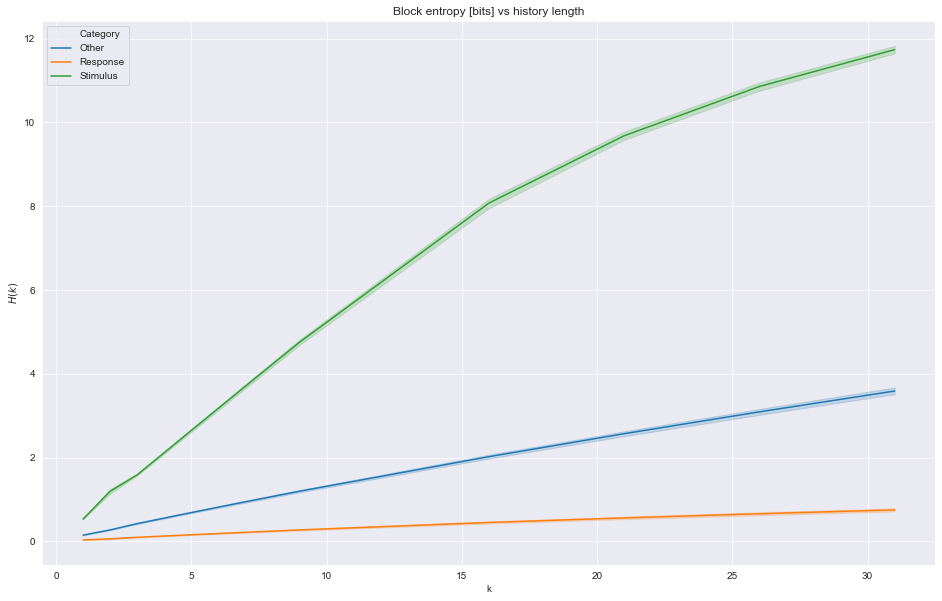

In [177]:
#fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
sns.lineplot(data=df, x='k', y=BLOCK_ENT, hue='Category')
plt.title('Block entropy [bits] vs history length')
plt.show()

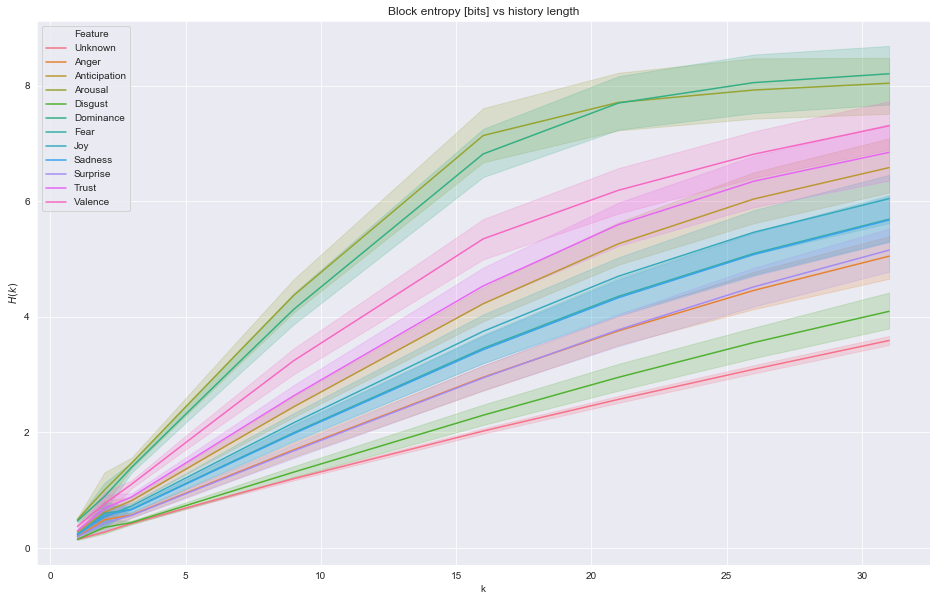

In [83]:
sns.lineplot(data=df, x='k', y=BLOCK_ENT, hue='Feature')
plt.title('Block entropy [bits] vs history length')
plt.show()

In [195]:
dflim = df[df.k == df.k.max()].sort_values(by=ER_NAME)
dflim.head()

$H(k)$  Category  Feature  \
Document                                  Subject                              
EN_1885_Barr,Amelia_JanVeedersWife_Novel  thee        0.0  Response  Sadness   
                                          thee        0.0  Response    Anger   
EN_1838_Martineau,Harriet_Deerbrook_Novel mr grey     0.0  Response  Disgust   
EN_1778_Burney,Fanny_Evelina_Novel        ma'am       0.0  Response  Disgust   
EN_1885_Barr,Amelia_JanVeedersWife_Novel  thee        0.0  Response  Disgust   

                                                    k  $h$  $\eta$      n  \
Document                                  Subject                           
EN_1885_Barr,Amelia_JanVeedersWife_Novel  thee     31  0.0     0.0  12099   
                                          thee     31  0.0     0.0  12099   
EN_1838_Martineau,Harriet_Deerbrook_Novel mr grey  31  0.0     0.0  43000   
EN_1778_Burney,Fanny_Evelina_Novel        ma'am    31  0.0     0.0  30295   
EN_1885_Barr,Amelia_JanVeedersWife_Novel  thee     31  0.0     0.0  12099   

                                                  reliability  
Document                                  Subject              
EN_1885_Barr,Amelia_JanVeedersWife_Novel  thee       Reliable  
                                          thee       Reliable  
EN_1838_Martineau,Harriet_Deerbrook_Novel mr grey    Reliable  
EN_1778_Burney,Fanny_Evelina_Novel        ma'am      Reliable  
EN_1885_Barr,Amelia_JanVeedersWife_Novel  thee       Reliable

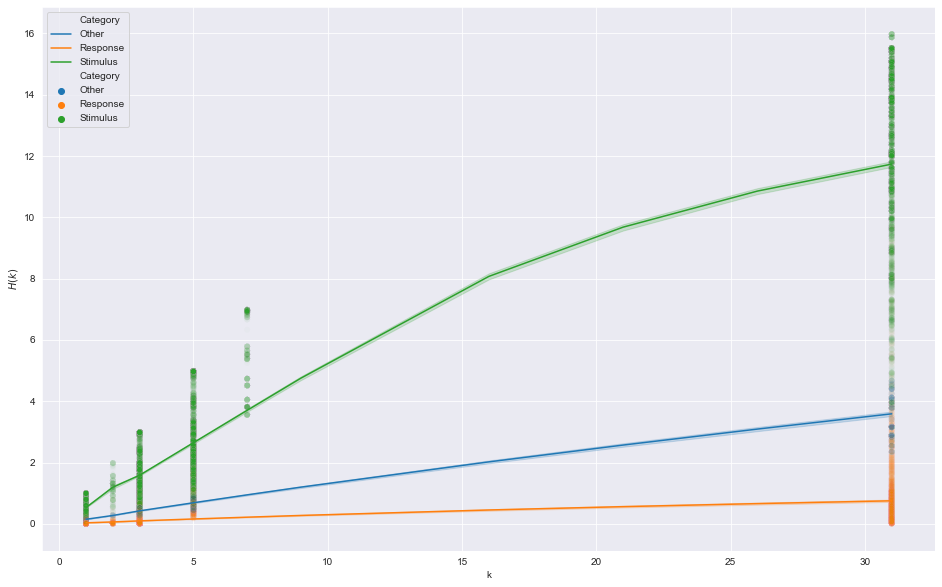

In [257]:
sns.lineplot(data=df, x='k', y=BLOCK_ENT, hue='Category')
sns.scatterplot(data=df[reliable], x='k', y=BLOCK_ENT, hue='Category', alpha=.02)

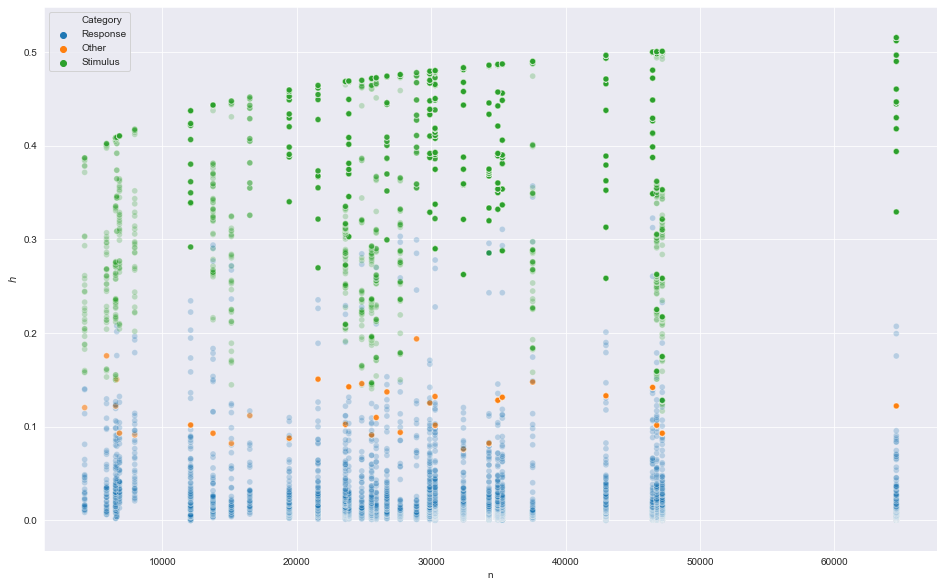

In [273]:
reliable_lim = dflim.reliability == 'Reliable'
sns.set_style("darkgrid")
sns.scatterplot(data=dflim[reliable_lim], x='n', y=ENT_RATE, hue='Category', alpha=.25)
sns.scatterplot(data=dflim[~reliable_lim], x='n', y=ENT_RATE, hue='Category', alpha=.025)
#sns.lineplot(data=dflim[reliable_lim], x='n', y=ENT_RATE, hue='Category', alpha=.25)

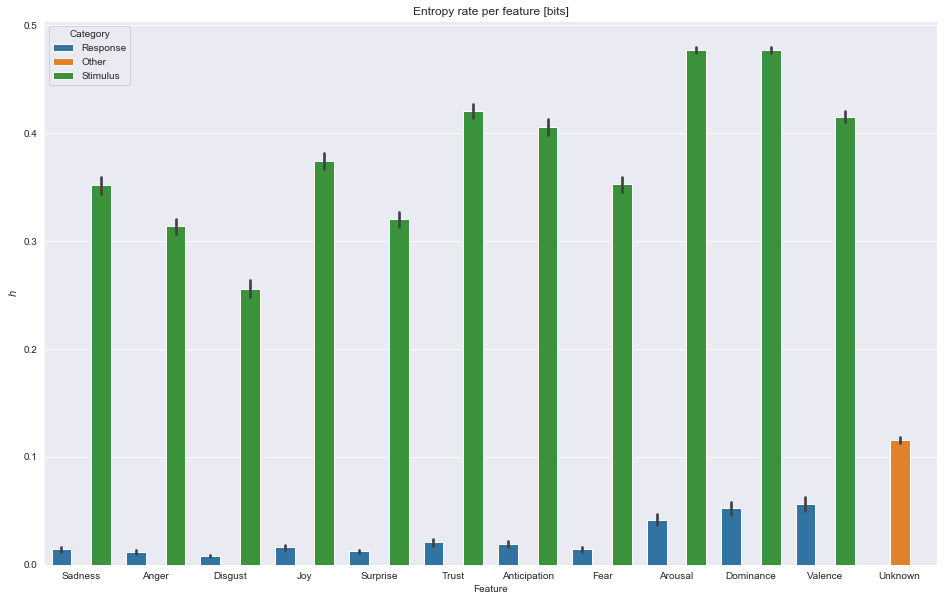

In [283]:
plt.title('Entropy rate per feature [bits]')
sns.barplot(data=dflim, x='Feature', y=ENT_RATE, hue='Category')

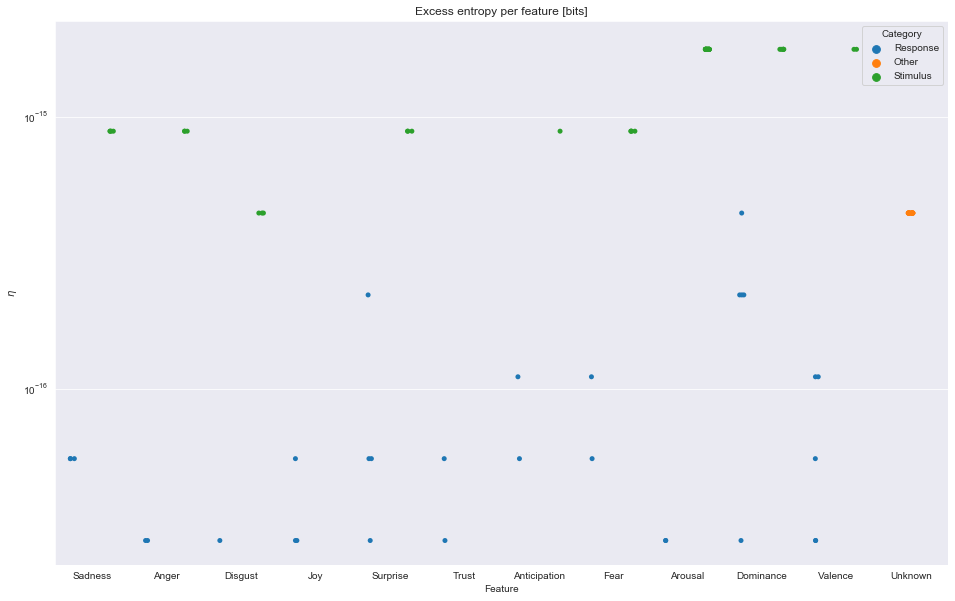

In [288]:
plt.title('Excess entropy per feature [bits]')
plt.yscale('log')
sns.stripplot(data=dflim, x='Feature', y=EXCESS_ENT, hue='Category', dodge=True, jitter=True)